# Data and AI Democratization through PromptToQueryResult Function

In the context of data and AI democratization, `PromptToQueryResult` could be a function that translates natural language prompts into database queries. This could be part of a larger system that allows non-technical users to interact with databases using natural language, which would democratize access to data and AI.

## Business Value and Domain Problem Solutions

### Business Value:

- **Increased Efficiency:** Non-technical users can retrieve data without needing to learn SQL or other query languages, or without needing to wait for technical staff to retrieve the data for them.
- **Reduced Costs:** Less time and resources are spent on training staff to use complex database systems, and less time is spent on data retrieval tasks by technical staff.
- **Improved Decision Making:** With easier access to data, decision-making can be data-driven and timely, leading to better business outcomes.

### Domain Problem Solved:

- **Data Accessibility:** One of the challenges in data democratization is making data accessible to non-technical users. `PromptToQueryResult` could help solve this problem by providing a natural language interface to databases.
- **AI Democratization:** By using AI to translate natural language prompts into database queries, `PromptToQueryResult` could also contribute to AI democratization. It could be part of a system that allows users to leverage the power of AI without needing to understand the technical details.

## Implementation Details

The selected code is written in Python and it's part of a larger program that uses a plugin-based architecture. The code is using a kernel object to manage plugins and their functions.

- **Variable Definitions:** First, two variables are defined: `plugins_directory` and `file_path`. The `plugins_directory` variable is set to the string `"plugins"`, which is presumably the directory where the plugins are stored. The `file_path` variable is set to `"data_schema.txt"`, which is likely a file that contains a data schema.

- **Reading Data Schema:** The `read_data_schema_from_file` function is then called with `file_path` as an argument. This function reads the data schema from the specified file and returns it as a string. The returned data schema is stored in the `data_schema` variable.

- **Conditional Plugin Import:** Next, there's an if-statement that checks the `prompt_rephrase` variable. If `prompt_rephrase` is true, the code imports a plugin named `"PromptPlugin"` from the plugins directory using the `import_plugin_from_prompt_directory` method of the kernel object. This method returns a dictionary-like object of functions provided by the plugin. The `"PromptRephraser"` function from the `"PromptPlugin"` plugin is then stored in the `rephraserFunction` variable.

- **Function Invocation:** The `rephraserFunction` is then invoked asynchronously using the `invoke` method of the kernel object. The `invoke` method is called with two arguments: the function to be invoked and a `KernelArguments` object that contains the data schema and a query. The result of the function invocation is stored in the `rephrased_prompt` variable.

- **Importing Another Plugin:** Finally, the code imports another plugin named `"DataPlugin"` from the plugins directory and stores the `"DatabaseDescriptor"` function from this plugin in the `descriptorFunction` variable. This function can presumably be used later in the code to describe a database based on the data schema.


In [60]:
import semantic_kernel as sk
from services import Service
import re
import sqlite3
import pandas as pd
import os

async def PromptToQueryResult(debug=False, prompt_rephrase=False):
    """
    Prompts the user for a query, rephrases the prompt if required, and executes the query using the Semantic Kernel.

    Args:
        debug (bool, optional): If True, prints debug information. Defaults to False.
        prompt_rephrase (bool, optional): If True, rephrases the prompt using a rephraser plugin. Defaults to False.

    Returns:
        DataFrame or any: The result of the executed query, or 'any' if no query is executed.
    """
    kernel = sk.Kernel()
    selectedService = Service.AzureOpenAI
    service_id = None
    if selectedService == Service.OpenAI:
        from semantic_kernel.connectors.ai.open_ai import OpenAIChatCompletion

        api_key, org_id = sk.openai_settings_from_dot_env()
        service_id = "gpt4-32k"
        kernel.add_service(
            OpenAIChatCompletion(service_id=service_id, ai_model_id="gpt4-32k", api_key=api_key, org_id=org_id),
        )
    elif selectedService == Service.AzureOpenAI:
        from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

        deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
        service_id = "aoai_chat_completion"
        kernel.add_service(
            AzureChatCompletion(service_id=service_id, deployment_name=deployment, endpoint=endpoint, api_key=api_key),
        )
    
    query = input("Enter your query: ")  # Get query from user
    rephrased_prompt = query
    
    plugins_directory = "plugins"
    file_path = "data_schema.txt"
    data_schema = read_data_schema_from_file(file_path)
    if(prompt_rephrase):
        promptFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "PromptPlugin")
        rephraserFunction = promptFunctions["PromptRephraser"]
        rephrased_prompt_result = await kernel.invoke(rephraserFunction, sk.KernelArguments(data_schema=data_schema, query=query))
        rephrased_prompt = rephrased_prompt_result.data if hasattr(rephrased_prompt_result, 'data') else str(rephrased_prompt_result)

    dataFunctions = kernel.import_plugin_from_prompt_directory(plugins_directory, "DataPlugin")
    descriptorFunction = dataFunctions["DatabaseDescriptor"]

    
    result = await kernel.invoke(descriptorFunction, sk.KernelArguments(data_schema=data_schema, query= rephrased_prompt))
    result_string = result.data if hasattr(result, 'data') else str(result)
    if(debug):
        print(result_string)
    matches_sql = parse_text_between_tags(result_string,"<sql>", "</sql>")

    if(prompt_rephrase):
        print("User query: " + query)
    print("Rephrased prompt: " + rephrased_prompt)
    if len(matches_sql) > 0:
        sql = matches_sql[0]
        if debug:
            print(sql)
        df = run_sql_query(sql)
    
    

    matches_python = parse_text_between_tags(result_string,"<python>", "</python>")
    if len(matches_python) > 0:
        if debug:
            print(matches_python[0])
        try:
            db_conn = os.getenv("DB_CONNECTION_STRING")
            conn = sqlite3.connect(db_conn)
            exec(matches_python[0])
            conn.close()
        except Exception as e:
            if debug:
                print('hata:' + e)
        except:
            print("An exception occurred")
    if len(matches_sql) > 0:
        df.head()
        return df
    else:  
        return any


def read_data_schema_from_file(file_path):
    """
    Reads the data schema from a file.

    Args:
        file_path (str): The path to the file containing the data schema.

    Returns:
        str: The contents of the file as a string.

    Raises:
        FileNotFoundError: If the file does not exist.

    """
    with open(file_path, 'r') as file:
        data_schema = file.read()
    return data_schema

def parse_text_between_tags(text, start_tag, end_tag):
    """
    Parses the text between the specified start and end tags.

    Args:
        text (str): The text to search within.
        start_tag (str): The start tag to look for.
        end_tag (str): The end tag to look for.

    Returns:
        list: A list of matches found between the start and end tags.
    """
    pattern = rf"{re.escape(start_tag)}(.*?){re.escape(end_tag)}"
    matches = re.findall(pattern, text, re.DOTALL)
    return matches

def run_sql_query(query):
    """
    Executes the given SQL query and returns the result as a pandas DataFrame.

    Parameters:
    query (str): The SQL query to be executed.

    Returns:
    pandas.DataFrame: The result of the SQL query as a DataFrame.
    """
    db_conn = os.getenv("DB_CONNECTION_STRING")
    conn = sqlite3.connect(db_conn)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df



User query: yıllara göre satış adetleri. histogram. x ekseni yıllar, y ekseni satış adetleri. MARKALARI YIĞIN/STACK ŞEKLİNDE GÖSTER.
Rephrased prompt: Create a histogram to display the total number of sales per year, with the x-axis representing the years and the y-axis representing the number of sales. Stack the sales by different brands to differentiate them within the histogram.


<Figure size 1000x600 with 0 Axes>

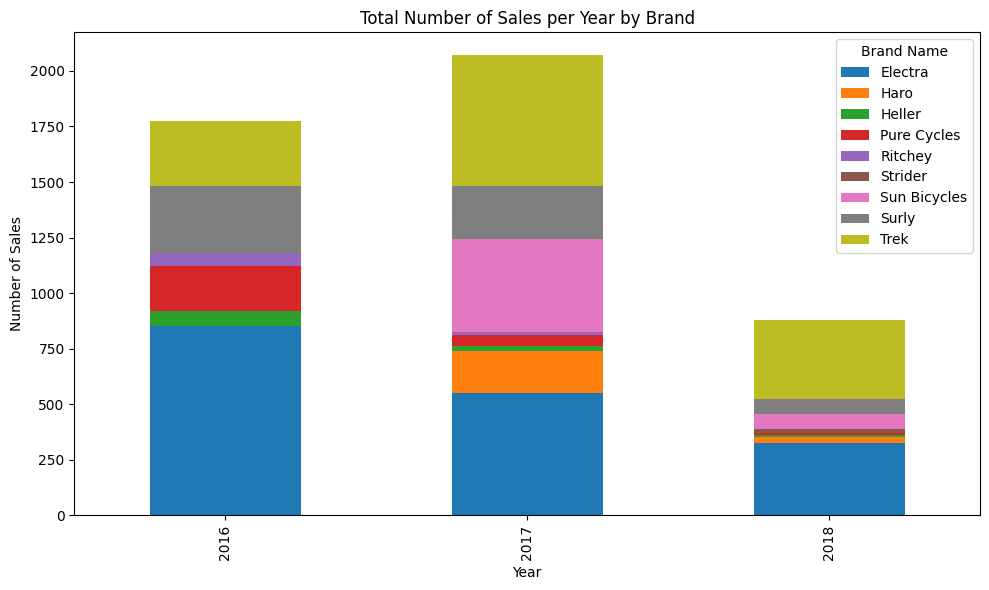

,year,brand_name,total_sales
0,2016,Electra,853
1,2016,Heller,67
2,2016,Pure Cycles,201
3,2016,Ritchey,62
4,2016,Surly,297
5,2016,Trek,293
6,2017,Electra,552
7,2017,Haro,189
8,2017,Heller,23
9,2017,Pure Cycles,49


In [62]:
await PromptToQueryResult(prompt_rephrase=True, debug=False)
